# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})
sns.set()

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

## Read In

In [3]:
df = pd.read_csv("./data/mammoth_mountain_snowfall_melted_table.csv")
df.head()

,Date,Month,Snow Fall
0,1970-01-01,Jan,78.0
1,1970-02-01,Feb,30.5
2,1970-03-01,Mar,46.0
3,1970-04-01,Apr,27.0
4,1970-05-01,May,0.0


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,Month,Snow Fall
Date,,
1970-01-01,Jan,78.0
1970-02-01,Feb,30.5
1970-03-01,Mar,46.0
1970-04-01,Apr,27.0
1970-05-01,May,0.0


In [5]:
df.tail()

,Month,Snow Fall
Date,,
2023-08-01,Aug,0.0
2023-09-01,Sep,0.0
2023-10-01,Oct,0.0
2023-11-01,Nov,14.0
2023-12-01,Dec,12.0


## Calculate Average Snowfall by Month

In [6]:
monthly_average = df.groupby("Month")[["Snow Fall"]].agg(np.mean)
monthly_average.rename(columns={"Snow Fall": "Monthly Average"}, inplace=True)
monthly_average

,Monthly Average
Month,
Apr,32.924074
Aug,2.870370
Dec,66.411111
Feb,69.761111
Jan,71.333333
Jul,0.000000
Jun,0.190741
Mar,63.718519
May,8.029630


## And Insert into Data Frame for Use as Exo Feature

In [7]:
df = (
    df.reset_index()
    .set_index(["Date", "Month"])
    .join(monthly_average, how="outer")
    .reset_index()
    .set_index("Date")
)

In [8]:
df.head(15)

,Month,Snow Fall,Monthly Average
Date,,,
1970-01-01,Jan,78.0,71.333333
1970-02-01,Feb,30.5,69.761111
1970-03-01,Mar,46.0,63.718519
1970-04-01,Apr,27.0,32.924074
1970-05-01,May,0.0,8.029630
1970-06-01,Jun,0.0,0.190741
1970-07-01,Jul,0.0,0.000000
1970-08-01,Aug,30.0,2.870370
1970-09-01,Sep,30.0,2.870370


# Extract Target

Arbitrarily limit from 2015 and on, to make the dataset easier to work with
- Also, stop it in May so that when predicting the last N months, we are finishing at the end of a ski season
- i.e. avoid trying to predict into the boring summer trough region

In [9]:
y_target = df["Snow Fall"]["2010":"2022-05-01"]
y_exog = df["Monthly Average"]["2010":"2022-05-01"]

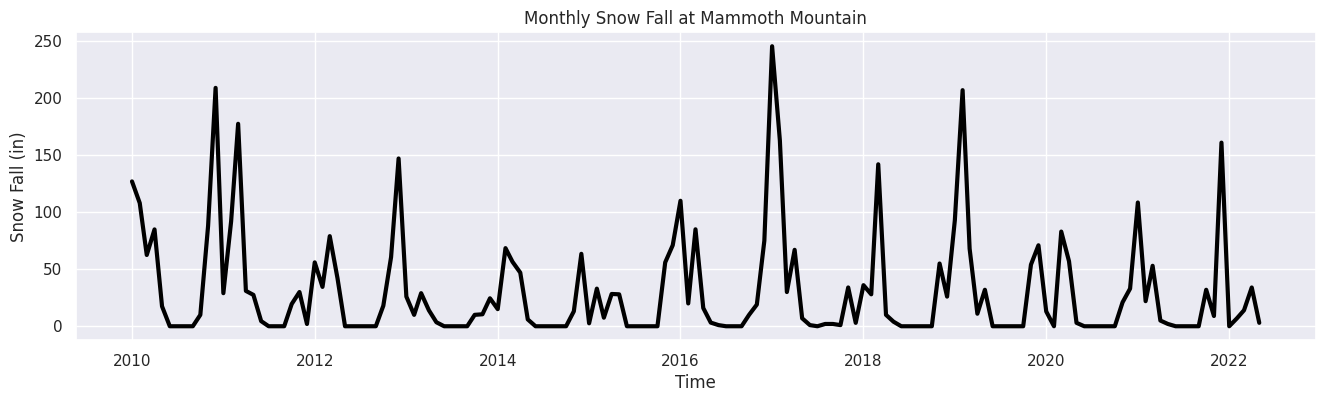

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(y_target, color="black", lw=3)
plt.title("Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Snow Fall (in)")
plt.show()

In [11]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, lags=10, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, lags=10, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

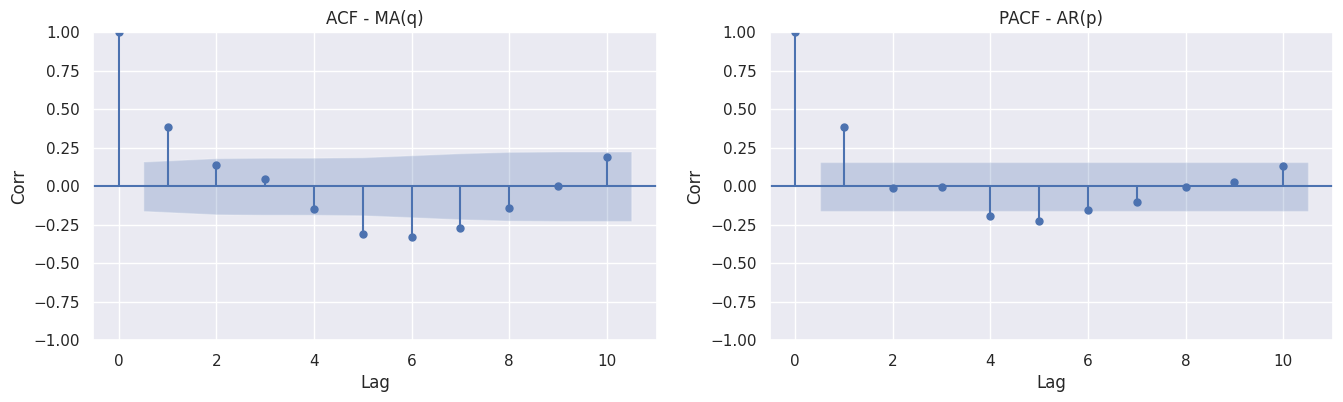

In [12]:
plot_acf_pacf(y_target)

# Train / Test Split

Defer the split to internals of helper functions
- Afraid of losing track of these and having them become separate and wrong from each other.

In [13]:
n_steps_future = 7

In [14]:
# if 0:
#     (y_history, y_future) = train_test_split(
#         y_target, shuffle=False, test_size=n_steps_future
#     )
#     (y_exog, y_exog_history, y_exog_future) = (None, None, None)
# else:
#     (y_history, y_future, y_exog_history, y_exog_future) = train_test_split(
#         y_target, y_exog, shuffle=False, test_size=n_steps_future
#     )

# Examine Seasonal and Trends

In [15]:
snowfall_period = 12

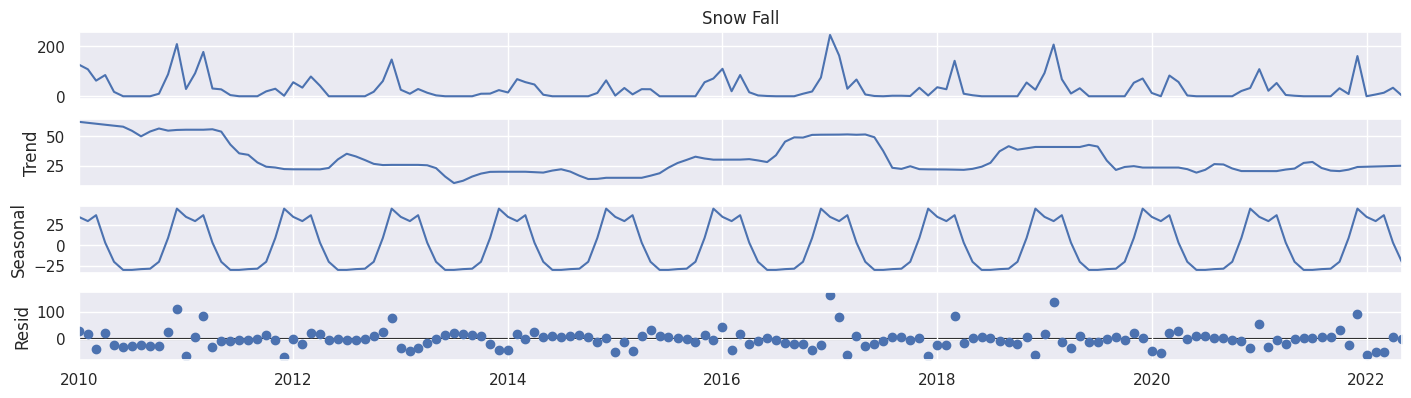

In [16]:
seasonal_decompose(
    y_target,
    model="additive",
    period=snowfall_period,
    extrapolate_trend=snowfall_period,
).plot().set_size_inches((16, 4))

plt.show()

# Fit with ARIMA

## Helper Functions

In [17]:
def get_errors_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred).round(1),
        "rmse": root_mean_squared_error(y_true, y_pred).round(1),
    }

In [18]:
def get_estimator_and_errors(y_target, n_steps_future, order, seasonal_order):
    # Split
    (y_history, y_future, y_exog_history, y_exog_future) = train_test_split(
        y_target, y_exog, shuffle=False, test_size=n_steps_future
    )

    # Fit
    estimator = ARIMA(
        y_history,
        order=order,
        seasonal_order=seasonal_order,
        exog=y_exog_history,
    ).fit()

    # Predict history and future
    y_hat = estimator.predict(
        start=y_target.index[0], end=y_target.index[-1], exog=y_exog_future
    )

    # Get errors
    (y_fit, y_forecast) = train_test_split(
        y_hat, shuffle=False, test_size=n_steps_future
    )

    train_test_errors = {
        "fit": get_errors_dict(y_history, y_fit),
        "forecast": get_errors_dict(y_future, y_forecast),
    }

    return (y_hat, train_test_errors)

## Parameter Search

Over (p, d, q) for stationary and (p, d, q, s) for seasonal, with s fixed = period

In [19]:
p_list = range(1, 3)
d_list = range(0, 2)
q_list = range(1, 3)

sp_list = range(1, 3)
sd_list = range(0, 2)
sq_list = range(1, 3)

best_error = np.Inf

if 1:
    # Bypass search and set a result
    best_order = (1, 0, 1)
    best_seasonal_order = (2, 0, 2, snowfall_period)
else:
    for p in p_list:
        for d in d_list:
            for q in q_list:
                for sp in sp_list:
                    for sd in sd_list:
                        for sq in sq_list:
                            order = (p, d, q)
                            seasonal_order = (sp, sd, sq, snowfall_period)
                            (y_hat, train_test_errors) = get_estimator_and_errors(
                                y_target, n_steps_future, order, seasonal_order
                            )
                            current_error = train_test_errors["forecast"]["mae"]
                            # current_error = train_test_errors["forecast"]["rmse"]
                            # current_error = train_test_errors["fit"]["rmse"]

                            if current_error < best_error:
                                best_error = current_error
                                best_order = order
                                best_seasonal_order = seasonal_order
                                print(
                                    "Best at order = %s, seasonal_order = %s, errors\n\t%s"
                                    % (
                                        str(order),
                                        str(seasonal_order),
                                        str(train_test_errors),
                                    )
                                )

In [20]:
(y_hat, train_test_errors) = get_estimator_and_errors(
    y_target, n_steps_future, best_order, best_seasonal_order
)
display(train_test_errors)

{'fit': {'mae': 20.0, 'rmse': 33.3}, 'forecast': {'mae': 37.7, 'rmse': 46.0}}

`{'fit': {'mae': 20.35201372825876, 'rmse': 33.253721157468846},`  
 `'forecast': {'mae': 37.67571578605102, 'rmse': 46.08397461541778}}`

## Save Result to CSV

In [21]:
saved_results_filename = "./data/monthly_snowfall_arima_with_exog.csv"
# y_hat.to_csv(saved_results_filename, index_label="Date")
y_hat_saved = pd.read_csv(saved_results_filename, index_col="Date", parse_dates=True)[
    y_hat.name
]

In [22]:
if not np.allclose(y_hat, y_hat_saved):
    plt.figure(figsize=(16, 4))
    plt.plot(y_hat_saved, label="Saved", color="black", lw=7)
    plt.plot(y_hat, label="Current", color="cyan", lw=2)
    plt.title(
        "Curent Result Different from Saved - diff errors = %s"
        % str(get_errors_dict(y_hat, y_hat_saved))
    )
    plt.legend()

In [23]:
# y_hat_saved[15] += 1.0e-3  # to demonstrate it is possible to fail this test
pd.testing.assert_series_equal(y_hat, y_hat_saved, check_names=False, check_freq=False)
# pd.concat([y_hat, y_hat_saved], axis=1)

## Plot of Fit

### Current Fit

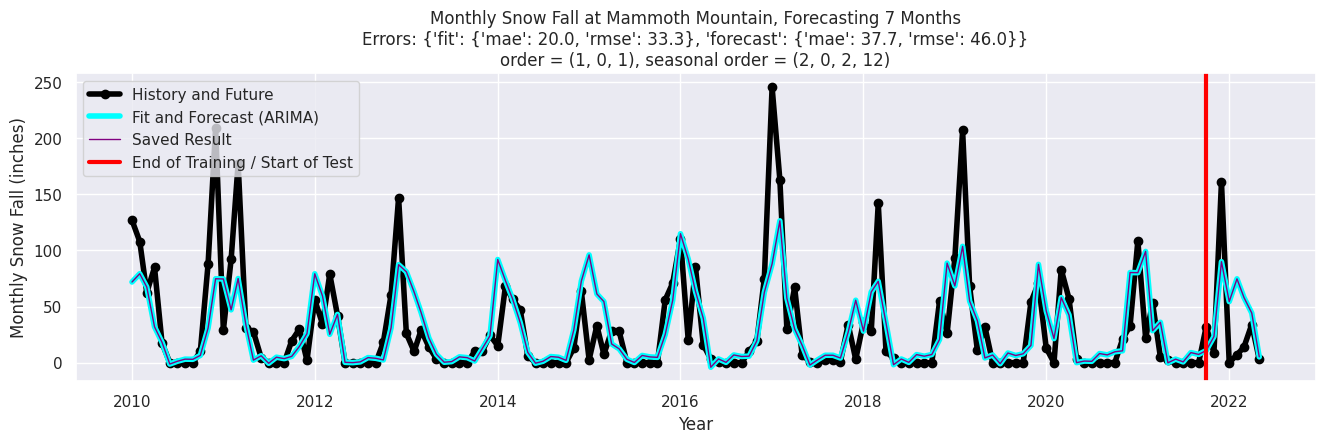

In [24]:
nplot = len(y_target) - n_steps_future
# nplot = 5 * n_steps_future

plt.figure(figsize=(16, 4))
plt.plot(
    y_target.tail(nplot + n_steps_future),
    color="black",
    label="History and Future",
    linestyle="solid",
    marker="o",
    lw=4,
)
plt.plot(
    y_hat.tail(nplot + n_steps_future),
    color="cyan",
    label="Fit and Forecast (ARIMA)",
    linestyle="solid",
    # marker="o",
    lw=4,
)
plt.plot(
    y_hat_saved.tail(nplot + n_steps_future),
    color="purple",
    label="Saved Result",
    linestyle="solid",
    # marker="o",
    lw=1,
)
plt.axvline(
    y_target.index[-n_steps_future - 1],
    color="red",
    label="End of Training / Start of Test",
    lw=3,
)

plt.title(
    "Monthly Snow Fall at Mammoth Mountain, Forecasting %d Months\nErrors: %s\norder = %s, seasonal order = %s"
    % (
        n_steps_future,
        str(train_test_errors),
        str(best_order),
        str(best_seasonal_order),
    )
)

plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

### Saved Plots

#### With Exo Feature - Monthly Average Snowfall

Look at how the stuff that is supposed to be zero is now pulled down to nearly zero

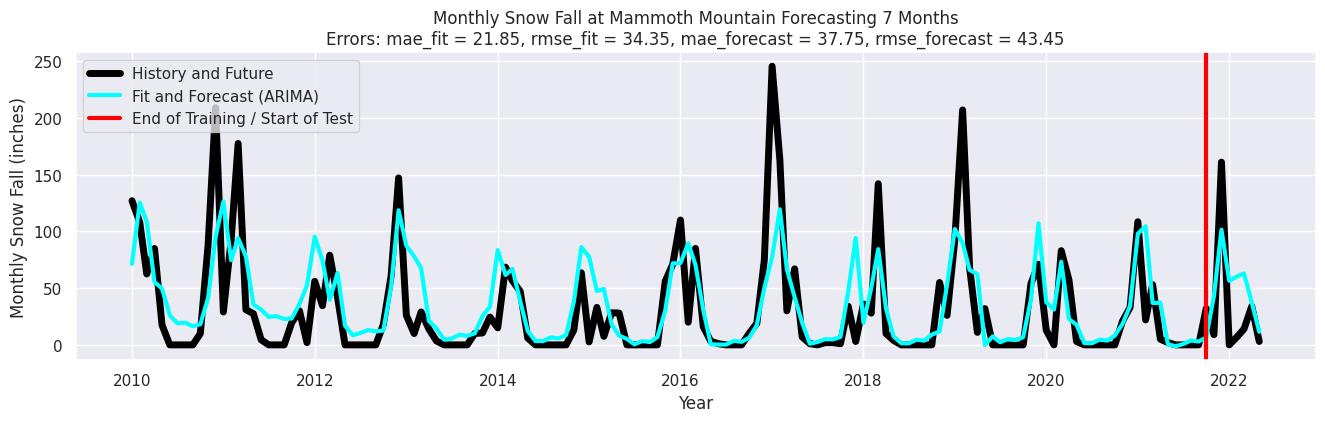

#### Saved Plot, No Exo

Look at how the stuff that is supposed to be zero is very not zero

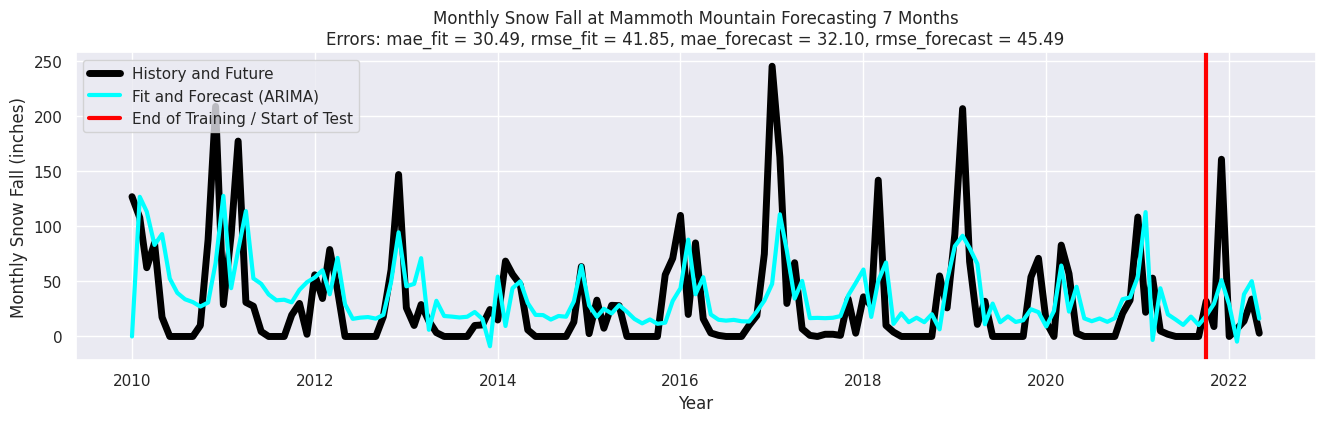

# ACF / PACF of Residual

Look ma, no non-zero corr coefs

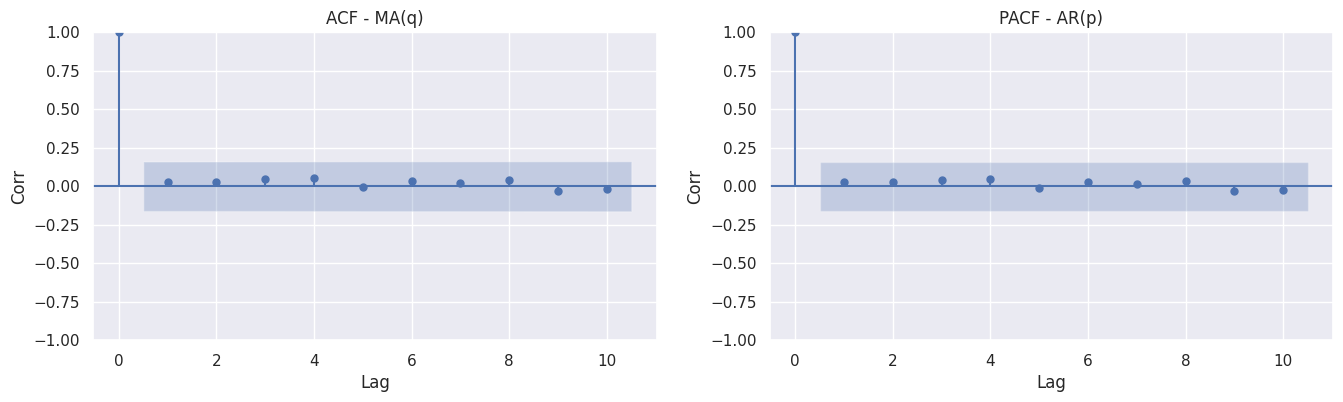

In [25]:
plot_acf_pacf(y_target - y_hat)